In [1]:
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from collections import defaultdict
import time
from sklearn.externals import joblib

In [2]:
LineReader = csv.reader(open('shuffled-full-set-hashed.csv'), delimiter=',', quotechar='|')
# LineReader = csv.reader(open('row160.csv'), delimiter=',', quotechar='|')
Rows = [(row[0],row[1]) for row in LineReader]
n_most_common  = 100

In [3]:
# # for num in [10,160,1600,20,320,6400]:
# num = 10000
# with open("row"+str(num)+".csv", 'w') as fd:
#     spamwriter = csv.writer(fd,  delimiter=',',quotechar='|')
#     for row in Rows[:num]:
#         spamwriter.writerow([row[0],row[1]])          

In [4]:
data = [row[1] for row in Rows]
target = [row[0] for row in Rows]
from collections import Counter
MyCounter = Counter(target)
idx2target = dict(enumerate(MyCounter.keys()) )
tar2idx = dict( (idx2target[idx],idx) for idx in range(len(idx2target)))

In [5]:
# filtering of train_data to reduce the dimensionality

WordsCount_dict = defaultdict(int)
for row_words in data: # much faster than Counter
    for w in row_words.split(): WordsCount_dict[w] +=1
import heapq        
Heap = []
for key in WordsCount_dict: 
    heapq.heappush(Heap, (-WordsCount_dict[key], key))
# print("len(Heap)", len(Heap))
words_most_common = set()
for i in range(n_most_common):
    w = heapq.heappop(Heap)
    words_most_common.add(w[1])
data_filter = [" ".join([w for w in words_line.split() if w in words_most_common])  for words_line in data]
train_data = data_filter[:]
del data

In [6]:
#-----------
#training data and dev data
# dev data (reservoir sampling)
# https://en.wikipedia.org/wiki/Reservoir_sampling-- Algorithm R 
from random import randint
def pick(num,k):
    """
    :type target: int
    :rtype: int
    """
    reservoir = [i for i in range(k)]
    for i in range(k,num):
        j = randint(0, i)
        if  j < k : reservoir[j] = i  # succinct
    return reservoir

dev_idxs = pick(len(Rows), len(Rows)/10)
dev_data = [data_filter[i] for i in dev_idxs]
dev_target_idx = [tar2idx[Rows[i][0]] for i in dev_idxs]
# training data
train_target_idx = [tar2idx[tar] for tar in target]
train_data = data_filter[:]
del data_filter

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('vect', CountVectorizer(lowercase = False, ngram_range = (1,3))),
                     ('tfidf', TfidfTransformer()), ('clf', MultinomialNB(alpha = 0.01))])

In [8]:
T0 = time.time()
text_clf.fit(train_data, train_target_idx)
print("Elapsed time:",time.time() - T0)

('Elapsed time:', 39.07653093338013)


In [9]:
T0 = time.time()
dev_predicted = text_clf.predict(dev_data)
print(np.mean(dev_predicted == dev_target_idx),"Elapsed time:",time.time() - T0)

(0.9382636655948553, 'Elapsed time:', 3.258575916290283)


In [10]:
# confusion matrix
n_categories= len(tar2idx)
confusion = np.zeros((n_categories, n_categories),dtype = np.float64)
for i in range(len(dev_target_idx)):
    confusion[ dev_target_idx[i] ][dev_predicted[i]] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

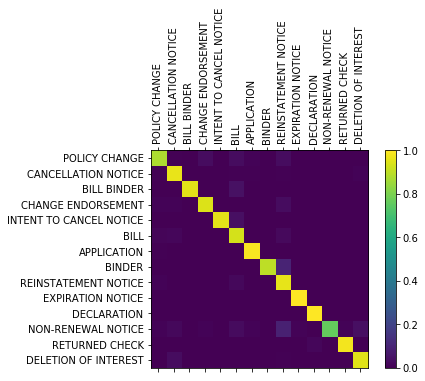

In [11]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
fig.colorbar(cax)
# Set up axes
ax.set_xticklabels([''] + list(tar2idx.keys()), rotation=90)
ax.set_yticklabels([''] + list(tar2idx.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
plt.show()
fig.savefig('dev_confusion.png')

In [12]:
T0 = time.time()
filename = 'NBclassifier.joblib'+ str(n_most_common)+'.pkl'
_ = joblib.dump(text_clf, filename, compress=9)
print("Elapsed time:",time.time() - T0)
del filename

('Elapsed time:', 53.1462299823761)


In [13]:
filename_supplementary = 'NBclassifier_supplementary.joblib'+ str(n_most_common)+'.pkl'
np.savez(filename_supplementary, idx2target = idx2target, tar2idx =tar2idx, words_most_common = words_most_common)

In [14]:
fname = "devresult0.csv"
with open(fname,'w') as fd:
    spamwriter = csv.writer(fd,delimiter=',', quotechar='|')
    for i in range(len(dev_predicted)):
        spamwriter.writerow([idx2target[dev_predicted[i]], idx2target[dev_target_idx[i]] ])  